# Optyx: A ZX-based Python library for networked quantum architectures

Optyx is an open-source Python library for designing, simulating, and optimizing networked, hybrid qubit–photon architectures. It offers a compositional, ZX/ZW-based string-diagram front end (built within the DisCoPy ecosystem) that lets you specify experiments mixing qubit registers with discrete-variable photonic modes, lossy channels, heralded measurements, and classical/quantum feedback. Optyx compiles these diagrams to optimized tensor networks and executes them with state-of-the-art contraction backends (Quimb + Cotengra), delivering substantial speedups on low-depth circuits. The result is an end-to-end workflow—from high-level syntax to numerics—well-suited for rapid prototyping of qubit-photon experiments.

## Basic Optyx syntax: the Hong-Ou-Mandel effect

We will present the basics of Optyx with a simple example from linear optics. 

The Hong–Ou–Mandel (HOM) effect is a two-photon interference phenomenon where indistinguishable photons entering a 50:50 beamsplitter “bunch” and exit together through the same output register. When their temporal, spectral, polarization, and spatial modes overlap perfectly, destructive interference suppresses the outcome with one photon in each output. This effect is a standard benchmark for photon indistinguishability in photonic experiments.

### Experiment definition

Circuits in Optyx are diagrams made of typed wires (qubits, photonic modes, classical bits) and generators (gates, sources, optics, measurements). You build them by connecting outputs to inputs (sequence) and placing blocks side-by-side (parallel); types must match at every connection. Generators carry parameters and labels; measurements produce classical wires you can route into later blocks. A circuit is just the set of generators plus the wiring between their ports.

Let us build a diagram to study the HOM effect.

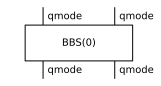

In [1]:
from optyx.photonic import BBS

# diagram generators:
# beam-splitter
beam_splitter = BBS(0)
beam_splitter.draw()

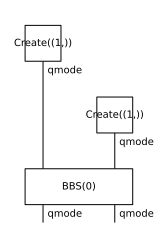

In [2]:
from optyx.photonic import Create

# diagram composition with monoidal syntax
# create two single-photon states and send them to a beam-splitter
hong_ou_mandel = (
    Create(1) @ Create(1) >>
    beam_splitter
)

hong_ou_mandel.draw()

The result of this experiment should be a zero probability of having single photons in two output modes:

 ![HOM](./hom.png "Hong-Ou-Mandel Effect")

### Diagram evaluation

Call `diagram.eval()` to evaluate a diagram (Quimb backend by default). It returns an evaluated object; use `.tensor.array` to extract the numeric tensor/array, or `.prob_dist()` to get an outcome distribution. You can chain it inline, e.g., `(...).eval().tensor.array`.

In [ ]:
# an amplitude (raw result of tensor contraction)
from optyx.photonic import Select
(
    hong_ou_mandel >> Select(1, 1)
).eval().tensor.array

array(-0.+0.j)

In [4]:
hong_ou_mandel.eval().prob_dist()

{(0, 2): 0.5, (1, 1): 4.9303806576313227e-32, (2, 0): 0.5}

## Function syntax and backends: qubit teleportation

Quantum teleportation transfers an unknown qubit state from sender (Alice) to receiver (Bob) using shared entanglement and two classical bits. Alice performs a joint Bell-state measurement on the unknown qubit and her half of an entangled pair, which projects Bob’s distant qubit into a state related to the original. She sends the two-bit outcome to Bob, who applies a corresponding Pauli correction (I, X, Z, or XZ) to recover the exact state. No information travels faster than light and the original is destroyed by measurement, so the state is relocated—not copied.

https://en.wikipedia.org/wiki/Quantum_teleportation#/media/File:Quantum_teleportation_circuit.svg :

<img src="teleport.svg" alt="Teleportation Protocol" width="800" style="max-width:100%;">

In [5]:
from optyx import qubit, bit
from optyx.qubits import Scalar

from optyx import Channel
from optyx.qubits import Z, X, H, Measure, Scalar, qubit, bit
from optyx.classical import BitControlledGate
from optyx.core import zx, diagram

### Define the protocol


Instead of wiring generators together with sequential (`>>`) and parallel (`@`) composition (which we call the monoidal syntax), you can treat each generator as a **function on its domain wires**. You **label the wires** and then **call generators with those labels**, which lets you feed specific wires directly into the right box without inserting explicit `Swap`s to reorder them. This makes complex diagrams easier to read and write, and mirrors the style used in **Guppy**; it’s an alternative surface syntax that’s equivalent to the usual `>>`/`@` composition.


In [6]:
# function syntax
# CNOT from ZX generators

@Channel.from_callable(
  dom=qubit @ qubit, cod=qubit @ qubit
)
def cnot(a, b):
  c, d = Z(1, 2)(a)
  Scalar(2 ** 0.5)()
  return c, X(2, 1)(d, b)

In [7]:
bell = Scalar(0.5 ** 0.5) @ Z(0, 2)

controlled_X = Channel(
  "Controlled-X",
  zx.X(2, 1) @ diagram.Scalar(2 ** 0.5),
  dom = bit @ qubit,
  cod = qubit
)

controlled_Z = Channel(
  "Controlled-Z",
  (
    zx.H @ diagram.bit >>
    zx.Z(2, 1) @ diagram.Scalar(2 ** 0.5)
  ),
  dom = bit @ qubit,
  cod = qubit
)

@Channel.from_callable(
  dom=qubit, cod=qubit
)
def teleportation(c):
  a, b = bell()
  cc, aa = cnot(c, a)
  c_ = Measure(1)(H()(cc))
  a_ = Measure(1)(aa)
  bb = controlled_X(a_, b)
  return controlled_Z(c_, bb)

In [8]:
# function syntax avoids explicit swaps and identity wires
# this is the equivalent monoidal syntax:

teleportation_monoidal_syntax = (
    qubit @ bell >>
    cnot @ qubit >>
    H() @ qubit ** 2 >>
    Measure(1) @ Measure(1) @ qubit >>
    bit @ controlled_X >>
    controlled_Z
)

### Verify the protocol

In [9]:
import numpy as np
from optyx.qubits import Id

# both implementations are equivalent
np.allclose(
    teleportation.eval().tensor.array,
    teleportation_monoidal_syntax.eval().tensor.array,
    Id(1).double().to_tensor().eval().array
)

True

Optyx evaluates diagrams via pluggable backends. By default it compiles a diagram to a tensor network, optimizes a contraction path with **cotengra**, and contracts it with **quimb** (CPU/GPU; dense/sparse). For linear-optical circuits, Optyx also exposes a **Perceval** backend using permanent-based algorithms, and a tensor-network-based **DisCoPy** backend; you can choose among these depending on the task.


In [10]:
# backends (Perceval, Discopy, Quimb)

from optyx.core.backends import (
    DiscopyBackend,
    QuimbBackend
)

np.allclose(
    teleportation.eval(DiscopyBackend()).tensor.array,
    teleportation.eval(QuimbBackend()).tensor.array
)

True

### Verify with PyZX

We can obtain the underlying CPTP map by doubling (CP-construction) an Optyx diagram:

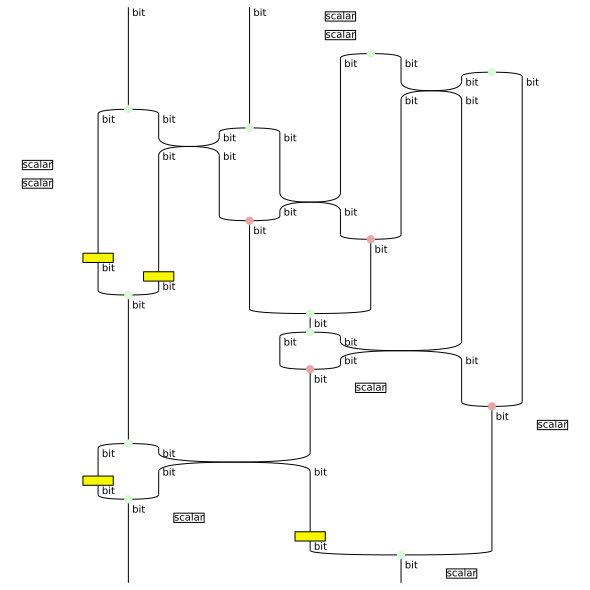

In [11]:
teleportation_monoidal_syntax.double().draw(figsize=(8, 8))

This way we can use PyZX and its optimisation/simplifications functionalities:

In [12]:
import pyzx
pyzx_graph = teleportation_monoidal_syntax.double().to_pyzx()

In [13]:
pyzx.full_reduce(pyzx_graph, quiet=True)
pyzx_graph.normalize()
pyzx.draw(pyzx_graph)

The diagram is a double identity diagram.

## Approximate contraction and photon loss: fusion teleportation

Teleportation with **fusion measurements** uses a Bell pair of dual-rail qubits as the channel: Alice fuses the input with her half using a Type-II fusion, reads the classical outcomes, and Bob applies the corresponding correction. In the **success** branch, the overall map is the **identity** on the teleported qubit up to a known Pauli byproduct, which Bob removes with a conditioned \(X\) correction. In the **failure** branch, the input is effectively measured and the opposite state is prepared at the output. For the standard Type-II scheme this yields identity with probability \(1/2\), and failure otherwise; the paper’s diagrams show both branches explicitly and how the correction restores the state.


Ursin, R., Jennewein, T., Aspelmeyer, M. et al. Quantum teleportation across the Danube. Nature 430, 849 (2004). https://doi.org/10.1038/430849a :

<img src="./teleportation_danube.png" alt="Fusion teleportation across the Danube" width="1150px">

Graphically, the fusion measurement we would like to use, takes the following form:

<img src="./fusion_ii.png" alt="Fusion measurement" width="1200px">


where $\underline{a}, \underline{b}, \underline{c}, \underline{d}$ are the measurement outcomes as the measured photon numbers. 

$\underline{s} = \underline{a} \oplus \underline{b}$

$\underline{k} = \underline{s} (\underline{b} + \underline{d}) + \neg \underline s (1 - \frac{\underline{a} + \underline{b}}{2})$

### Define the protocol

In [14]:
from optyx.photonic import DualRail

dual_rail_encoded_bell = (
    bell >>
    DualRail(1) @ DualRail(1)
)

In [15]:
from optyx.classical import PostselectBit, BitControlledGate
from optyx.photonic import Phase
from optyx.photonic import HadamardBS, qmode

# postselect on fusion success
fusion_failure_processing = PostselectBit(1)

# apply the box if the control bit is 1, otherwise apply an identity channel
correction = BitControlledGate(
    HadamardBS() >>
    (Phase(0.5) @ qmode) >>
    HadamardBS()
)

In [16]:
from optyx.photonic import FusionTypeII

@Channel.from_callable(
    dom=qubit, cod=qmode @ qmode
)
def fusion_teleportation(a):
    dual_rail_encoded_input = DualRail(1)(a)
    b, c, d, e = dual_rail_encoded_bell()
    s, k = FusionTypeII()(*dual_rail_encoded_input, b, c)
    fusion_failure_processing(s)
    dr_output_1, dr_output_2 = correction(k, d, e)
    return dr_output_1, dr_output_2

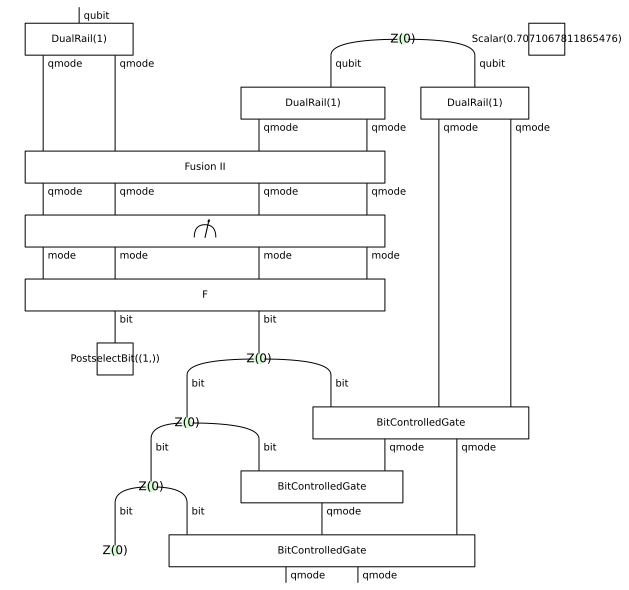

In [17]:
from optyx.photonic import FusionTypeII

fusion_teleportation_monoidal_syntax = (
    DualRail(1) @ dual_rail_encoded_bell >>
    FusionTypeII() @ qmode**2 >>
    fusion_failure_processing @ correction
)

fusion_teleportation_monoidal_syntax.foliation().draw(figsize=(8, 8))


### Verify the protocol

In [18]:
import numpy as np
from optyx.photonic import Id

array_teleportation = fusion_teleportation_monoidal_syntax.eval().tensor.array
array_dr = (DualRail(1) @ Scalar(0.5**0.5)).double().to_tensor().eval().array

np.allclose(array_teleportation[:, :, :2, :2, :2, :2], array_dr)


True

### Approximate contraction with Quimb and Cotengra

Approximate contraction in Optyx uses cotengra to plan a low-cost contraction with memory-aware slicing, then executes it in quimb with optional compression of intermediates. Instead of multiplying tensors exactly, large merges are factorized and truncated (e.g., SVD) so only the dominant singular components are kept; you trade speed and memory for a controlled approximation error. Tightening the truncation tolerance (or increasing the allowed bond size) yields higher accuracy at higher cost, while more aggressive truncation/slicing gives faster, lower-memory contractions with small, quantifiable loss in fidelity.

In [19]:
def _flat(x):
    return np.asarray(x, dtype=complex).ravel()

def cosine_similarity(SU, SV):
    a, b = _flat(SU), _flat(SV)
    num = abs(np.vdot(a, b))
    den = np.linalg.norm(a) * np.linalg.norm(b)
    if den == 0:
        return 0.0
    return float(num / den)

/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: not enough values to unpack (expected 2, got 1). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: not enough values to unpack (expected 2, got 1). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: not enough values to unpack (expected 2, got 1). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/mateuszkupper/Documents/optyx/.venv/lib/python

Text(0.5, 1.0, 'Fusion-based Teleportation similarity vs Contraction Chi')

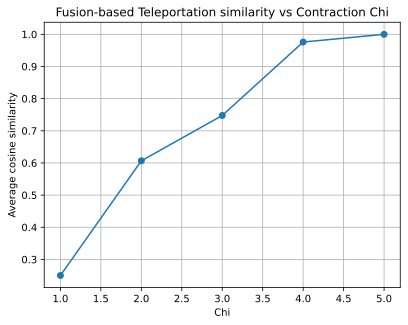

In [20]:
from cotengra import HyperCompressedOptimizer

# cosine similarity between the result of exact contaction and approximate contraction for different chis
errors = []
for chi in range(1, 6):
    optimiser = HyperCompressedOptimizer(
        chi=chi
    )
    error_for_chi = []
    for _ in range(10):
         error_for_chi.append(
             cosine_similarity(
                 fusion_teleportation.eval(QuimbBackend(optimiser)).tensor.array,
                 array_teleportation
             )
         )
    errors.append(np.median(error_for_chi))

import matplotlib.pyplot as plt
plt.plot(range(1, 6), errors, marker='o')
plt.grid()
plt.xlabel('Chi')
plt.ylabel('Average cosine similarity')
plt.title('Fusion-based Teleportation similarity vs Contraction Chi')


### Photon loss and channel fidelity

Photon loss is when a photon that should arrive simply doesn’t. In Optyx, you model this by placing a dedicated loss generator exactly where the loss occurs; its single parameter is the photon survival probability. Photon loss is the primary failure mode for photonic qubits. In photonic computing it breaks multi-photon interference and reduces the success of fusion/measurement steps. That’s why if we want to study architectures, thresholds, and mitigation (repeaters, multiplexing, loss-tolerant encodings), we need to be able to model photon loss accurately.

In [21]:
from optyx.photonic import FusionTypeII, PhotonLoss

# photo loss is one of the main error sources in photonic quantum computing
def fusion_teleportation_with_photon_loss(p):
    @Channel.from_callable(
        dom=qubit, cod=qmode**2
    )
    def fusion_teleportation(a):
        dr_input_1, dr_input_2 = DualRail(1)(a)
        b, c, d, e = dual_rail_encoded_bell()
        # apply photon loss to all modes here:
        #-----------------------------------
        dr_input_1_loss, dr_input_2_loss, b_loss, c_loss, d_loss, e_loss = (
            PhotonLoss(p)(dr_input_1), PhotonLoss(p)(dr_input_2),
            PhotonLoss(p)(b), PhotonLoss(p)(c),
            PhotonLoss(p)(d), PhotonLoss(p)(e)
        )
        #-----------------------------------
        s, k = FusionTypeII()(dr_input_1_loss, dr_input_2_loss, b_loss, c_loss)
        fusion_failure_processing(s)
        output_rail_1, output_rail = correction(k, d_loss, e_loss)
        return output_rail_1, output_rail
    return fusion_teleportation

In [22]:
from optyx.core.channel import Spider, Diagram

def get_perm(n):
    return sorted(sorted(list(range(n))), key=lambda i: i % 2)

def channel_fidelity(diagram_1, diagram_2):
    bell_1 = Channel.tensor(*[Spider(0, 2, ty) for ty in diagram_1.dom])
    permutation_1 = Diagram.permutation(get_perm(len(bell_1.cod)), bell_1.cod)

    bell_2 = Channel.tensor(*[Spider(0, 2, ty) for ty in diagram_2.dom])
    permutation_2 = Diagram.permutation(get_perm(len(bell_2.cod)), bell_2.cod)

    choi_1 = bell_1 >> permutation_1 >> (diagram_1 @ diagram_1.dom)
    choi_2 = bell_2 >> permutation_2 >> (diagram_2 @ diagram_2.dom)

    return (choi_1 >> choi_2.dagger()).eval().tensor.array


/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Fusion-based Teleportation: Photon Survival Probability vs Fidelity')

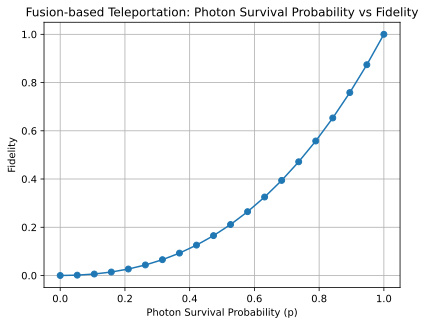

In [23]:
import numpy as np
import matplotlib.pyplot as plt

ps = np.linspace(0.0, 1.0, 20)

# compute fidelity for different photon loss probabilities
F_avg_vals = []
succ_probs = []
for p in ps:
    S_impl = fusion_teleportation_with_photon_loss(p)
    S_tgt  = fusion_teleportation_monoidal_syntax
    s = channel_fidelity(S_impl, S_tgt)

    succ_probs.append(s)

plt.figure()
plt.plot(ps, succ_probs, marker='o')
plt.grid(True)
plt.xlabel('Photon Survival Probability (p)')
plt.ylabel('Fidelity')
plt.title('Fusion-based Teleportation: Photon Survival Probability vs Fidelity')


## Photon distinguishability: distributed entanglement generation

Distributed entanglement generation links two distant quantum nodes (A and B) by creating a shared entangled pair. Each node emits a photon that travels to a shared site, where the photons interfere and a joint (Bell-state) detection flags success — instantly projecting A and B into an entangled state. Because attempts often fail due to loss, the process is repeated-until-success with timing. This is the core primitive behind quantum networks and repeaters, enabling long-distance QKD, teleportation, and multi-node protocols.

Main, D., Drmota, P., Nadlinger, D.P. et al. Distributed quantum computing across an optical network link. Nature 638, 383–388 (2025). https://doi.org/10.1038/s41586-024-08404-x~ :

![Distributed entanglement](./distributed_entanglement.png "An example of distributed entanglement generation")



### Fusion and photon distinguishability

#### Define the protocol

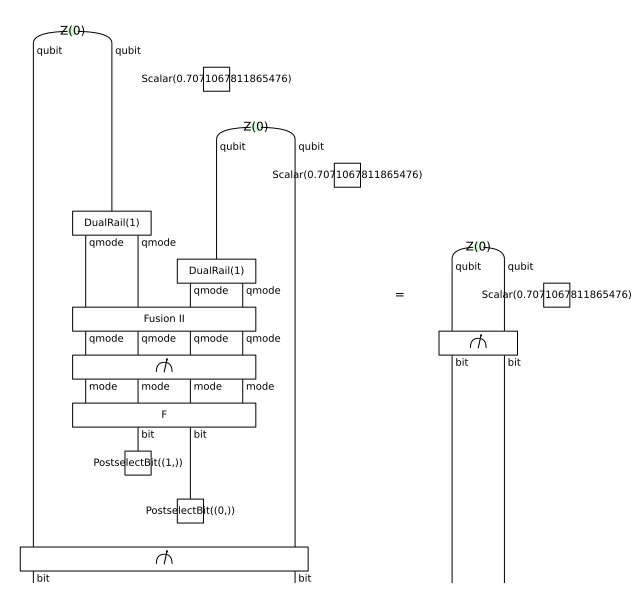

In [24]:
from optyx.qubits import Z, Scalar, Id, Measure
from optyx.photonic import DualRail
from optyx.classical import PostselectBit
from discopy.drawing import Equation

bell_state = Z(0, 2) @ Scalar(0.5 ** 0.5)

# generators introducing new qubits accepting internal states
internal_state_1 = [1, 0]
internal_state_2 = [0, 1]
dual_rail_encoding = lambda state: DualRail(1, internal_states=[state])
encoding_layer =  dual_rail_encoding(internal_state_1) @ dual_rail_encoding(internal_state_2)

# postselect on fusion success and no errors
post_select = PostselectBit(1) @ PostselectBit(0)

protocol = (
    bell_state @ bell_state >>
    Id(1) @ (encoding_layer >> FusionTypeII() >> post_select) @ Id(1)
)
measure = Measure(2)

Equation(protocol >> measure, bell_state >> measure).draw(figsize=(8, 8))

#### Define a set of internal states with varying degrees of distinguishability

We test how partial photon distinguishability affects a heralded entanglement link. The experiment uses the overlap between two internal two-mode states (`rotated_unit_vectors`), encodes them into dual-rail photons (`dual_rail_encoding`), and performs a Type-II fusion with postselection (`FusionTypeII() >> post_select`). We then project onto the target Bell state (`... >> bell_state.dagger()`) to read off the heralded-state quality, and use a discard step (`... >> Discard(2)`) to extract the success probability. Plotting these versus the state overlap reveals how distinguishability simultaneously degrades fidelity and lowers the entanglement generation rate.


In [25]:
import math

# internal states - 2 dimensional - move further and further apart
def rotated_unit_vectors(n: int = 10):
    for i in range(n):
        theta = i * (math.pi / 2) / (n - 1)
        yield (math.cos(theta), math.sin(theta))

unit_vectors = list(rotated_unit_vectors(15))

#### Run the experiments

In [26]:
from optyx.qubits import Discard

inner_product_states = []
inner_product_bell_states = []

result_bell = bell_state.eval().tensor.array.flatten()
result_bell = result_bell / np.linalg.norm(result_bell)

for vector in unit_vectors:
    encoding_layer =  dual_rail_encoding(internal_state_1) @ dual_rail_encoding(vector)
    experiment = bell_state @ bell_state >> Id(1) @ (encoding_layer >> FusionTypeII()
                                                                                >> post_select) @ Id(1)

    f = (experiment >> bell_state.dagger()).inflate(2).eval().tensor.array
    normalisation = (experiment >> Discard(2)).inflate(2).eval().tensor.array

    inner_product_states.append(np.inner(vector, internal_state_1))
    inner_product_bell_states.append(f/normalisation)

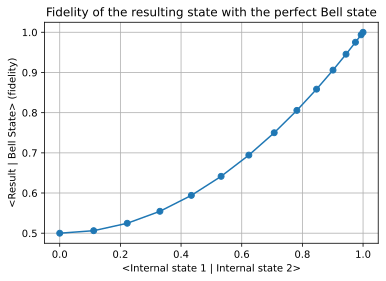

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(inner_product_states, inner_product_bell_states, marker='o')
plt.xlabel('<Internal state 1 | Internal state 2>')
plt.ylabel('<Result | Bell State> (fidelity)')
plt.title('Fidelity of the resulting state with the perfect Bell state')
plt.grid(True)
plt.show()

## Interfacing with external libraries

### Graphix

Open graphs supported only for now (graph + measurements; desire to implement deterministically - no corrections)

The pattern is not consistent with flow or gflow structure.


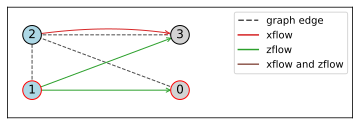

In [28]:
import graphix

circuit = graphix.Circuit(2)
circuit.cnot(0, 1)

pattern = circuit.transpile().pattern

pattern.draw_graph()

In [29]:
simulator = graphix.simulator.PatternSimulator(pattern, backend="statevector")
graphix_result = simulator.run().psi.conj()

In [30]:
from optyx import qubits

optyx_zx = qubits.Circuit(pattern)

optyx_res = (
    qubits.Ket("+")**2 >> optyx_zx
).eval().amplitudes()

In [31]:
for keys in optyx_res.keys():
    assert np.isclose(optyx_res[keys], graphix_result[keys], atol=1e-6)

### Perceval circuits and processors

#### Define the protocol in Perceval

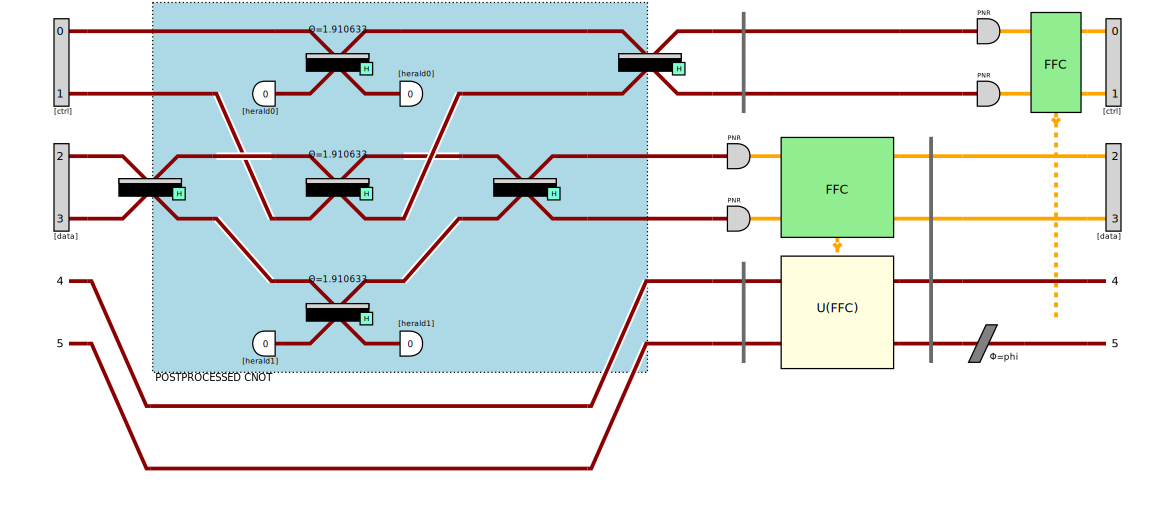

In [32]:
import perceval as pcvl

p = pcvl.Processor("SLOS", 6)
p.add(0, pcvl.catalog["postprocessed cnot"].build_processor())

p.add(0, pcvl.BS.H())
p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())

ff_X = pcvl.FFCircuitProvider(
  2, 0, pcvl.Circuit(2)
)
ff_X.add_configuration(
  [0, 1], pcvl.PERM([1, 0])
)
p.add(2, ff_X)

phi = pcvl.P("phi")
ff_Z = pcvl.FFConfigurator(
  2, 3,
  pcvl.PS(phi),
  {"phi": 0}
).add_configuration(
  [0, 1],
  {"phi": np.pi}
)
p.add(0, ff_Z)

pcvl.pdisplay(p, recursive=True)

In [33]:
from optyx.qubits import Ket

state = Ket("+") >> Z(1, 1, 0.3)
state_array = state.eval().tensor.array
state_array = state_array / np.linalg.norm(state_array)

#### Evaluate the protocol in Perceval

In [34]:
to_transmit = (complex(state_array[0])*pcvl.BasicState([1, 0]) +
               complex(state_array[1])*pcvl.BasicState([0, 1]))

sg = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
bell_state = sg.bell_state("phi+")

input_state = to_transmit * bell_state
p.min_detected_photons_filter(2)

input_state *= pcvl.BasicState([0, 0])

p.with_input(input_state)

In [35]:
result_perceval = p.probs()

#### Convert to Optyx and simulate

In [36]:
from optyx import Channel

optyx_diagram = Channel.from_perceval(p)

In [37]:
from optyx.qubits import Scalar, Ket
from optyx.photonic import DualRail

bell_state = Z(0, 2) @ Scalar(0.5**0.5)
transmit = Ket("+") >> Z(1, 1, 0.3)

input_state = transmit @ bell_state

protocol = (
    input_state >>
    DualRail(3) >>
    Channel.from_perceval(p)
)

In [38]:
result_optyx = protocol.eval().prob_dist()

In [39]:
def check_dict_agreement(d1, d2, rtol=1e-5, atol=1e-8):
    for key in d1.keys() - d2.keys():
        assert np.isclose(d1[key], 0, rtol=rtol, atol=atol)
    for key in d2.keys() - d1.keys():
        assert np.isclose(d2[key], 0, rtol=rtol, atol=atol)
    for key in d1.keys() & d2.keys():
        assert np.isclose(d1[key], d2[key], rtol=rtol, atol=atol)

In [40]:
check_dict_agreement(
    {tuple(k): v for k, v in dict(result_perceval["results"]).items()},
    result_optyx
)